In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import ast
plt.style.use("seaborn")

In [2]:
weights_df = pd.read_csv("weights.csv", sep=";")
weights_df["cluster"] += 1
weights_df.head()

,user_id,cluster,weight
0,1049656,1,0.119843
1,1049656,2,0.337917
2,1049656,3,0.281925
3,1049656,4,0.260314
4,1055118,1,0.036036


In [3]:
classification = weights_df.sort_values(by="weight", ascending=False).groupby(by=["user_id"]).head(1).set_index("user_id")["cluster"]
classification_df = pd.DataFrame(classification)
classification_df.head()

,cluster
user_id,
4292780,2
31977800,2
34705051,2
10883488,1
23528874,2


In [4]:
classification_df.reset_index(inplace=True)
classification_df.groupby(by="cluster").count()

,user_id
cluster,
1,7
2,1917
3,9
4,140


In [5]:
track_cluster_df = pd.read_csv("track_to_cluster.csv", sep=";")
track_cluster_df.head()

,track_id,cluster
0,53,1
1,86,-1
2,127,1
3,182,1
4,219,1


In [6]:
cluster_sizes_df = track_cluster_df.groupby(by="cluster").size()
cluster_sizes_df = cluster_sizes_df.to_frame()
cluster_sizes_df.columns = ["size"]
cluster_sizes_df.drop(-1, inplace=True)
cluster_sizes_df.index += 1
cluster_sizes_df.head()

,size
cluster,
1,11588
2,85663
3,6446
4,27446


In [7]:
#N = len(track_cluster_df)
N = cluster_sizes_df["size"].sum()
N

131143

In [8]:
idfs = []
for count in cluster_sizes_df["size"].values:
    idf = np.log10(N / count)
    idfs.append(idf)
print(idfs)

[1.0537366277426747, 0.18495183454035624, 1.308454813098083, 0.6792660552700823]


In [9]:
idfs_df = pd.DataFrame({"cluster": [1, 2, 3, 4], "score": idfs})
idfs_df.set_index("cluster", inplace=True)
idfs_df

,score
cluster,
1,1.053737
2,0.184952
3,1.308455
4,0.679266


In [10]:
merged_df = weights_df.merge(idfs_df, left_on="cluster", right_index=True)
merged_df.head()

,user_id,cluster,weight,score
0,1049656,1,0.119843,1.053737
4,1055118,1,0.036036,1.053737
8,1056935,1,0.121143,1.053737
12,1070023,1,0.054945,1.053737
16,1072752,1,0.185864,1.053737


In [11]:
user_normalized_df = merged_df[["user_id", "cluster"]].copy()
user_normalized_df["weight"] = merged_df.apply(lambda r: r["weight"] * r["score"], axis=1)
user_normalized_df.head()

,user_id,cluster,weight
0,1049656,1,0.126283
4,1055118,1,0.037972
8,1056935,1,0.127653
12,1070023,1,0.057898
16,1072752,1,0.195852


In [12]:
user_normalized_df["cluster"].unique()

array([1, 2, 3, 4], dtype=int64)

In [13]:
classification = user_normalized_df.sort_values(by="weight", ascending=False).groupby(by=["user_id"]).head(1).set_index("user_id")["cluster"]
classification_df = pd.DataFrame(classification)
classification_df.head()

,cluster
user_id,
10883488,1
35212267,3
38189090,3
22113634,3
3704198,3


In [14]:
classification_df.reset_index(inplace=True)
classification_df.groupby(by="cluster").count()

,user_id
cluster,
1,396
2,900
3,102
4,675


In [15]:
classification_df.to_csv("classification_clean.csv", sep=";", index=False)

In [16]:
classification_df.head()

,user_id,cluster
0,10883488,1
1,35212267,3
2,38189090,3
3,22113634,3
4,3704198,3


In [17]:
users_df = pd.read_csv("../feature_engineering/data/low_main_users.txt")[["user_id", "age", "gender"]]
users_df.head()

,user_id,age,gender
0,1049656,35,m
1,1055118,34,m
2,1056935,30,m
3,1070023,32,m
4,1072752,48,m


In [18]:
len(users_df)

2074

In [19]:
df = users_df.merge(classification_df, left_on="user_id", right_on="user_id").set_index("user_id")
df = df[df["age"] != -1]
df = df[df["gender"] != "n"]
df.head()

,age,gender,cluster
user_id,,,
1049656,35,m,3
1055118,34,m,2
1056935,30,m,2
1070023,32,m,2
1072752,48,m,1


In [20]:
cluster_sizes = df.groupby("cluster").size()
df.groupby("cluster")["gender"].value_counts() / cluster_sizes

cluster  gender
1        m         0.626984
         f         0.373016
2        m         0.673913
         f         0.326087
3        m         0.823529
         f         0.176471
4        m         0.824895
         f         0.175105
dtype: float64

In [21]:
df.groupby("cluster").size()

cluster
1    252
2    690
3     68
4    474
dtype: int64

In [22]:
# all tracks
#cluster_idfs = {1: 1.0960800290887567, 2: 0.22877319102552013, 3: 1.3484314902299182, 4: 0.7174210757738761}
# only clustered tracks
cluster_idfs = {1: 1.0537366277426747, 2: 0.18495183454035624, 3: 1.308454813098083, 4: 0.6792660552700823}
idf_df = pd.DataFrame.from_dict(cluster_idfs, orient="index")
idf_df.columns = ["score"]
idf_df.index.name = "cluster"
idf_df

,score
cluster,
1,1.053737
2,0.184952
3,1.308455
4,0.679266


In [23]:
weights_with_idf_df = weights_df.merge(idf_df, left_on="cluster", right_index=True)
weights_with_idf_df["idf_weight"] = weights_with_idf_df["score"] * weights_with_idf_df["weight"]
weights_with_idf_df = weights_with_idf_df[["user_id", "cluster", "idf_weight"]]
weights_with_idf_df.head()

,user_id,cluster,idf_weight
0,1049656,1,0.126283
4,1055118,1,0.037972
8,1056935,1,0.127653
12,1070023,1,0.057898
16,1072752,1,0.195852


In [24]:
weights_df.head()

,user_id,cluster,weight
0,1049656,1,0.119843
1,1049656,2,0.337917
2,1049656,3,0.281925
3,1049656,4,0.260314
4,1055118,1,0.036036


In [25]:
weighted_weights_df = weights_with_idf_df.pivot(index="user_id", columns="cluster", values="idf_weight")
#weighted_weights_df = weights_df.pivot(index="user_id", columns="cluster", values="weight")
weighted_weights_df.fillna(0, inplace=True)
weighted_weights_df = weighted_weights_df.stack().to_frame()
weighted_weights_df.columns = ["weight"]
weighted_weights_df.reset_index(inplace=True)
weighted_weights_df.head()

,user_id,cluster,weight
0,1049656,1,0.126283
1,1049656,2,0.062498
2,1049656,3,0.368887
3,1049656,4,0.176823
4,1055118,1,0.037972


In [26]:
#classification_df.columns = ["user_id", "prediction"]
weighted_weights_df = weighted_weights_df.merge(classification_df, left_on="user_id", right_on="user_id")
weighted_weights_df.columns = ["user_id", "cluster", "weight", "prediction"]
weighted_weights_df.head()

,user_id,cluster,weight,prediction
0,1049656,1,0.126283,3
1,1049656,2,0.062498,3
2,1049656,3,0.368887,3
3,1049656,4,0.176823,3
4,1055118,1,0.037972,2


In [27]:
from sklearn.preprocessing import MinMaxScaler
normed_weights_df = weighted_weights_df.copy()
normed_weights_df.set_index("user_id", inplace=True)
normed_weights_df.head()

normalization_constants = normed_weights_df.groupby(by="user_id")["weight"].sum()
for user_id, group in normed_weights_df.groupby(by="user_id"):
    const = normalization_constants.loc[user_id]
    new_weights = group["weight"] / const

    normed_weights_df.loc[user_id, "weight"] = new_weights
normed_weights_df.head()

,cluster,weight,prediction
user_id,,,
1049656,1,0.171932,3
1049656,2,0.085091,3
1049656,3,0.502235,3
1049656,4,0.240742,3
1055118,1,0.163355,2


In [28]:
normed_weights_df.groupby(by="user_id")["weight"].sum().head()

user_id
1049656    1.0
1055118    1.0
1056935    1.0
1070023    1.0
1072752    1.0
Name: weight, dtype: float64

In [29]:
normed_weights_df.head()

,cluster,weight,prediction
user_id,,,
1049656,1,0.171932,3
1049656,2,0.085091,3
1049656,3,0.502235,3
1049656,4,0.240742,3
1055118,1,0.163355,2


In [27]:
weighted_weights_df.groupby(by=["prediction", "cluster"]).describe()["weight"]

count      mean       std       min       25%       50%  \
prediction cluster                                                            
1          1        396.0  0.226913  0.087271  0.120784  0.164530  0.207795   
           2        396.0  0.117945  0.020900  0.000000  0.106724  0.120016   
           3        396.0  0.068663  0.054733  0.000000  0.029717  0.059122   
           4        396.0  0.064176  0.042559  0.000000  0.028465  0.056399   
2          1        900.0  0.055842  0.037584  0.000000  0.024080  0.047918   
           2        900.0  0.154961  0.012755  0.121697  0.146598  0.155467   
           3        900.0  0.020167  0.020530  0.000000  0.005542  0.013877   
           4        900.0  0.063678  0.036897  0.000000  0.032576  0.063824   
3          1        102.0  0.121323  0.059085  0.000000  0.078877  0.113715   
           2        102.0  0.081300  0.027864  0.017339  0.060204  0.083725   
           3        102.0  0.286249  0.120932  0.130845  0.204656  0.253534   
           4        102.0  0.153869  0.072527  0.013094  0.106845  0.142280   
4          1        675.0  0.050654  0.037254  0.000000  0.021198  0.043861   
           2        675.0  0.102245  0.023200  0.016291  0.087408  0.105473   
           3        675.0  0.073282  0.056016  0.000000  0.030429  0.059176   
           4        675.0  0.233058  0.076410  0.124232  0.173896  0.216722   

                         75%       max  
prediction cluster                      
1          1        0.267095  1.053737  
           2        0.132514  0.157282  
           3        0.090568  0.413974  
           4        0.094499  0.207737  
2          1        0.083855  0.152874  
           2        0.164413  0.184952  
           3        0.028831  0.130344  
           4        0.091741  0.142322  
3          1        0.161199  0.279806  
           2        0.102823  0.145092  
           3        0.337886  0.767896  
           4        0.194886  0.325535  
4          1        0.070347  0.215537  
           2        0.120803  0.141188  
           3        0.102580  0.351907  
           4        0.275523  0.562151

In [63]:
means = weighted_weights_df.groupby(by=["prediction", "cluster"]).describe()["weight"]["mean"].groupby("prediction").apply(list).to_frame().to_numpy()
means

array([[list([0.226913385412516, 0.11794452370581822, 0.068662639112675, 0.06417585356938207])],
       [list([0.05584243849088402, 0.15496131622306883, 0.020167254374064143, 0.06367807705145767])],
       [list([0.12132255732452826, 0.08129974950017363, 0.28624945469222546, 0.1538692558388889])],
       [list([0.050654425220906574, 0.10224506829589125, 0.07328198163751748, 0.2330577336112815])]],
      dtype=object)

In [64]:
stds = weighted_weights_df.groupby(by=["prediction", "cluster"]).describe()["weight"]["std"].groupby("prediction").apply(list).to_frame().to_numpy()
stds

array([[list([0.08727120111383742, 0.020899656015398695, 0.054733028933388495, 0.042559316301531036])],
       [list([0.03758448832004005, 0.012754671897836748, 0.020529540795059167, 0.036897358362577314])],
       [list([0.05908548561862641, 0.027863669604463005, 0.12093174376503532, 0.07252711279565412])],
       [list([0.0372539532290745, 0.02319999147990407, 0.0560155809018667, 0.07641013989383125])]],
      dtype=object)

In [30]:
q1 = weighted_weights_df.groupby(by=["prediction", "cluster"]).describe()["weight"]["25%"].groupby("prediction").apply(list).to_frame().to_numpy()
q1

array([[list([0.1645297430224099, 0.10672356808958217, 0.02971654875871419, 0.02846471607822957])],
       [list([0.024080078975645187, 0.1465975223269425, 0.005542345083689526, 0.032575918413896114])],
       [list([0.07887739238088715, 0.060204481715046915, 0.20465602199412009, 0.10684525639438482])],
       [list([0.021198404723230427, 0.08740825853813432, 0.030429181699955416, 0.17389645174579635])]],
      dtype=object)

In [31]:
q3 = weighted_weights_df.groupby(by=["prediction", "cluster"]).describe()["weight"]["75%"].groupby("prediction").apply(list).to_frame().to_numpy()
q3

array([[list([0.26709514382975186, 0.13251367034517733, 0.09056793080671863, 0.09449933120015472])],
       [list([0.08385526633133236, 0.16441349571630204, 0.028830841662148745, 0.09174053645550079])],
       [list([0.16119909422427112, 0.10282287304865959, 0.33788625009662204, 0.19488646685962352])],
       [list([0.07034694850018414, 0.12080343169403326, 0.10257952142749371, 0.27552278500848837])]],
      dtype=object)

In [70]:
angles = np.linspace(0, 2*np.pi, 4, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

%matplotlib qt
plt.style.use("seaborn")
sns.set(font_scale=1.3)
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
colors = ["blue", "orange", "green", "red"]
for c in range(0, 4):
    m = means[c][0]# / np.sum(means[c][0])
    borders = stds[c][0]
    
    stats_m = np.concatenate((m, [m[0]]))
    stats_b = np.concatenate((borders, [borders[0]]))
    
    #lower_border = stats_m - stats_b
    #upper_border = stats_m + stats_b

    #lower_border = np.concatenate((q1[c][0], [q1[c][0][0]])) / np.sum(q1[c][0])
    #upper_border = np.concatenate((q3[c][0], [q3[c][0][0]])) / np.sum(q3[c][0])
    
    #fig = plt.figure()
    #ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats_m / np.sum(means[c][0]), 'o-', linewidth=1, label=r"$U_{C_" + str(c+1) + "}$", color=colors[c])
    #ax.fill_between(angles, lower_border / np.sum(means[c][0]), upper_border / np.sum(means[c][0]), linewidth=1, color=colors[c], alpha=0.3)
    #ax.fill_between(angles, lower_border, upper_border, linewidth=1, color=colors[c], alpha=0.3)
    ax.set_thetagrids(angles * 180/np.pi, [r"$C_1$", r"$C_2$", r"$C_3$", r"$C_4$"])
    ax.grid(True)
    #plt.ylim(0, 1)
    plt.ylim(0, 0.6)
plt.legend()

In [45]:
weights_df.head()

,user_id,cluster,weight
0,1049656,1,0.119843
1,1049656,2,0.337917
2,1049656,3,0.281925
3,1049656,4,0.260314
4,1055118,1,0.036036


In [30]:
summed_scores_df = weighted_weights_df.groupby(by="user_id")["weight"].sum().to_frame()
summed_scores_df.columns = ["sum"]
summed_scores_df.head()

,sum
user_id,
1049656,0.734491
1055118,0.232453
1056935,0.407604
1070023,0.367873
1072752,0.568534


In [31]:
merged_df = weighted_weights_df.merge(summed_scores_df, left_on="user_id", right_index=True)
merged_df["normed"] = merged_df["weight"] / merged_df["sum"]
merged_df = merged_df[["user_id", "cluster", "prediction", "normed"]]
merged_df.head()

,user_id,cluster,prediction,normed
0,1049656,1,3,0.171932
1,1049656,2,3,0.085091
2,1049656,3,3,0.502235
3,1049656,4,3,0.240742
4,1055118,1,2,0.163355


In [32]:
weights_with_idf_df.head()

,user_id,cluster,idf_weight
0,1049656,1,0.126283
4,1055118,1,0.037972
8,1056935,1,0.127653
12,1070023,1,0.057898
16,1072752,1,0.195852


In [33]:
q = 0.25
merged_df["kl"] = merged_df["normed"].apply(lambda p: p * np.log2(p) - p * np.log2(q))
kl_dist_df = merged_df.groupby(by="user_id")["kl"].sum().to_frame()
kl_dist_df.columns = ["KL"]
kl_dist_df = kl_dist_df.merge(classification_df, left_index=True, right_on="user_id")
kl_dist_df.head()

,KL,user_id,cluster
83,0.267198,1049656,3
926,0.864320,1055118,2
2045,0.070673,1056935,2
2002,0.140975,1070023,2
713,0.050160,1072752,1


In [34]:
kl_dist_df.groupby("cluster")["KL"].mean()

cluster
1    0.327241
2    0.518098
3    0.231112
4    0.379611
Name: KL, dtype: float64

([<matplotlib.axis.XTick at 0x214c1cd50f0>,
 <a list of 4 Text xticklabel objects>)

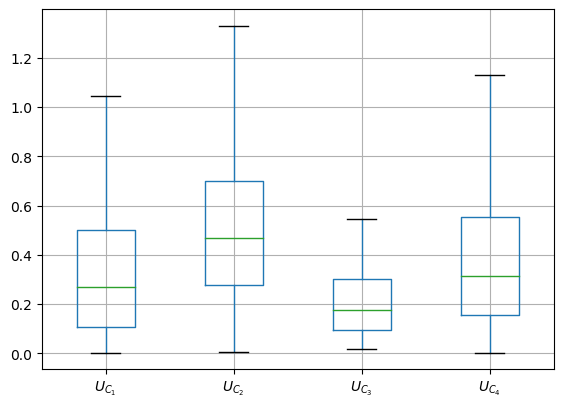

In [35]:
plt.style.use("default")
kl_dist_df.boxplot(column="KL", by="cluster", showfliers=False)
plt.suptitle("")
plt.title("")
plt.xlabel("")
plt.xticks([1, 2, 3, 4], [r"$U_{C_1}$", r"$U_{C_2}$", r"$U_{C_3}$", r"$U_{C_4}$"])

In [36]:
merged_df["h"] = merged_df.groupby(by="user_id")["normed"].apply(lambda p: -p * np.log2(p))
entropy_df = merged_df.groupby(by="user_id")["h"].sum().to_frame()
entropy_df.head()

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,h
user_id,
1049656,1.732802
1055118,1.135680
1056935,1.929327
1070023,1.859025
1072752,1.949840


In [37]:
distance_df = kl_dist_df.merge(entropy_df, left_on="user_id", right_index=True)
distance_df.head()

,KL,user_id,cluster,h
83,0.267198,1049656,3,1.732802
926,0.864320,1055118,2,1.135680
2045,0.070673,1056935,2,1.929327
2002,0.140975,1070023,2,1.859025
713,0.050160,1072752,1,1.949840


In [38]:
# see https://stats.stackexchange.com/questions/111445/analysis-of-kullback-leibler-divergence
distance_df["dist"] = distance_df["KL"] / distance_df["h"]
distance_df.head()

,KL,user_id,cluster,h,dist
83,0.267198,1049656,3,1.732802,0.154200
926,0.864320,1055118,2,1.135680,0.761060
2045,0.070673,1056935,2,1.929327,0.036631
2002,0.140975,1070023,2,1.859025,0.075833
713,0.050160,1072752,1,1.949840,0.025725


In [39]:
%matplotlib qt
plt.style.use("default")
distance_df.boxplot(column="dist", by="cluster", showfliers=False)
plt.suptitle("")
plt.title("")
plt.xlabel("")
plt.xticks([1, 2, 3, 4], [r"$U_{C_1}$", r"$U_{C_2}$", r"$U_{C_3}$", r"$U_{C_4}$"])

([<matplotlib.axis.XTick at 0x214c22b5978>,
 <a list of 4 Text xticklabel objects>)

In [55]:
weights_df[["cluster", "weight"]].boxplot(by="cluster", showmeans=True)

In [56]:
df = weights_with_idf_df.merge(classification_df, left_on="user_id", right_on="user_id")
df.columns = ["user_id", "cluster", "idf_weight", "prediction"]
df.head()

,user_id,cluster,idf_weight,prediction
0,1049656,1,0.126283,3
1,1049656,2,0.062498,3
2,1049656,3,0.368887,3
3,1049656,4,0.176823,3
4,1055118,1,0.037972,2


In [57]:
df["idf_weight"].var()

0.00649257385095967

In [58]:
df.groupby("prediction")["idf_weight"].var()

prediction
1    0.007419
2    0.003189
3    0.011890
4    0.007661
Name: idf_weight, dtype: float64

In [59]:
df.groupby(["prediction", "cluster"])["idf_weight"].var()

prediction  cluster
1           1          0.007616
            2          0.000403
            3          0.002932
            4          0.001775
2           1          0.001350
            2          0.000163
            3          0.000413
            4          0.001301
3           1          0.003377
            2          0.000776
            3          0.014624
            4          0.005260
4           1          0.001347
            2          0.000538
            3          0.003114
            4          0.005839
Name: idf_weight, dtype: float64

In [60]:
user_track_df = pd.read_csv("../feature_engineering/data/user_track.csv", sep=";")
user_track_df.head()

,user_id,track_id,artist_id
0,31435741,53,21
1,31435741,86,32
2,31435741,127,44
3,31435741,182,57
4,31435741,219,65


In [61]:
track_genres_df = pd.read_csv("../feature_engineering/data/track_genres.csv", sep=";", header=None)
track_genres_df.columns = ["track_id", "genres"]
track_genres_df = track_genres_df[track_genres_df["genres"] != "[]"]
track_genres_df.head()

,track_id,genres
0,4868,"['soul', 'pop', 'singersongwriter', 'blues', '..."
1,2900,"['electronic', 'indiepop', 'shoegaze', 'dreamp..."
2,572665,"['soul', 'pop', 'singersongwriter', 'blues', '..."
3,2897,"['indierock', 'electronic', 'indiepop', 'postp..."
4,15100,"['folk', 'indiefolk', 'banjo', 'folkrock', 'bl..."


In [62]:
df = user_track_df.merge(track_genres_df, left_on="track_id", right_on="track_id").merge(classification_df, left_on="user_id", right_on="user_id")
df.head()

,user_id,track_id,artist_id,genres,cluster
0,31435741,53,21,"['pop', 'rock', 'soul', 'poprock', 'poprock', ...",2
1,31435741,86,32,"['indierock', 'electronic', 'rock', 'postpunk'...",2
2,31435741,127,44,"['synthpop', 'pop', 'electronic', 'rock', 'sin...",2
3,31435741,182,57,"['rock', 'alternativerock', 'poprock', 'pop', ...",2
4,31435741,219,65,"['christianrock', 'rock']",2


In [63]:
df = df[["user_id", "cluster", "track_id"]]

In [64]:
df.head()

,user_id,cluster,track_id
0,31435741,2,53
1,31435741,2,86
2,31435741,2,127
3,31435741,2,182
4,31435741,2,219


In [66]:
dominant_genres = ["rock", "pop", "electronic", "metal", "alternativerock", "indierock"]

In [67]:
def jaccard(vec1, vec2):
    intersection = set(vec1).intersection(set(vec2))
    union = set(vec1).union(set(vec2))
    
    return len(intersection) / len(union)    

In [68]:
avg_pairwise_jaccard = [[] for _ in range(4)]
i = 1
for index1, data1 in df.groupby(by=["cluster", "user_id"])["track_id"].apply(set).to_frame().iterrows():
    c, uid1 = index1
    tracks1 = [g for g in data1.values[0] if g not in dominant_genres]
    sim = []
    df_c = df.groupby(by=["cluster", "user_id"])["track_id"].apply(set).to_frame().loc[c]
    for uid2, data2 in df_c.iterrows():
        tracks2 = tracks1 = [g for g in data2.values[0] if g not in dominant_genres]
        jacc = jaccard(tracks1, tracks2)
        sim.append(jacc)
    avg_pairwise_jaccard[c-1].append(np.mean(sim))
    
    print(i / 2073)
    i += 1
    
    
        
        
        

0.000482392667631452
0.000964785335262904
0.001447178002894356
0.001929570670525808
0.00241196333815726
0.002894356005788712
0.003376748673420164
0.003859141341051616
0.004341534008683068
0.00482392667631452
0.005306319343945972
0.005788712011577424
0.006271104679208876
0.006753497346840328
0.00723589001447178
0.007718282682103232
0.008200675349734683
0.008683068017366137
0.009165460684997588
0.00964785335262904
0.010130246020260492
0.010612638687891944
0.011095031355523395
0.011577424023154847
0.0120598166907863
0.012542209358417752
0.013024602026049204
0.013506994693680656
0.013989387361312108
0.01447178002894356
0.014954172696575013
0.015436565364206465
0.015918958031837915
0.016401350699469366
0.01688374336710082
0.017366136034732273
0.017848528702363725
0.018330921369995177
0.01881331403762663
0.01929570670525808
0.019778099372889532
0.020260492040520984
0.020742884708152436
0.021225277375783887
0.02170767004341534
0.02219006271104679
0.022672455378678243
0.023154848046309694
0.02

0.19874577906415822
0.19922817173178967
0.19971056439942114
0.2001929570670526
0.20067534973468404
0.2011577424023155
0.20164013506994694
0.20212252773757838
0.20260492040520983
0.20308731307284128
0.20356970574047276
0.2040520984081042
0.20453449107573565
0.2050168837433671
0.20549927641099855
0.20598166907863
0.20646406174626145
0.20694645441389292
0.20742884708152437
0.20791123974915582
0.20839363241678727
0.20887602508441871
0.20935841775205016
0.2098408104196816
0.21032320308731306
0.21080559575494454
0.21128798842257598
0.21177038109020743
0.21225277375783888
0.21273516642547033
0.21321755909310178
0.21369995176073323
0.2141823444283647
0.21466473709599615
0.2151471297636276
0.21562952243125905
0.2161119150988905
0.21659430776652194
0.2170767004341534
0.21755909310178484
0.21804148576941632
0.21852387843704776
0.2190062711046792
0.21948866377231066
0.2199710564399421
0.22045344910757356
0.220935841775205
0.22141823444283648
0.22190062711046793
0.22238301977809938
0.22286541244573

0.4018330921369995
0.402315484804631
0.4027978774722624
0.40328027013989387
0.4037626628075253
0.40424505547515677
0.4047274481427882
0.40520984081041966
0.4056922334780511
0.40617462614568256
0.40665701881331406
0.4071394114809455
0.40762180414857696
0.4081041968162084
0.40858658948383986
0.4090689821514713
0.40955137481910275
0.4100337674867342
0.41051616015436565
0.4109985528219971
0.41148094548962855
0.41196333815726
0.41244573082489144
0.4129281234925229
0.41341051616015434
0.41389290882778584
0.4143753014954173
0.41485769416304874
0.4153400868306802
0.41582247949831164
0.4163048721659431
0.41678726483357453
0.417269657501206
0.41775205016883743
0.4182344428364689
0.4187168355041003
0.4191992281717318
0.4196816208393632
0.42016401350699467
0.4206464061746261
0.4211287988422576
0.42161119150988907
0.4220935841775205
0.42257597684515197
0.4230583695127834
0.42354076218041486
0.4240231548480463
0.42450554751567776
0.4249879401833092
0.42547033285094066
0.4259527255185721
0.4264351181

0.6087795465508924
0.6092619392185239
0.6097443318861553
0.6102267245537868
0.6107091172214182
0.6111915098890497
0.6116739025566812
0.6121562952243126
0.6126386878919441
0.6131210805595755
0.613603473227207
0.6140858658948384
0.6145682585624699
0.6150506512301013
0.6155330438977328
0.6160154365653642
0.6164978292329957
0.6169802219006271
0.6174626145682586
0.61794500723589
0.6184273999035215
0.618909792571153
0.6193921852387844
0.6198745779064159
0.6203569705740473
0.6208393632416788
0.6213217559093102
0.6218041485769417
0.622286541244573
0.6227689339122046
0.623251326579836
0.6237337192474675
0.6242161119150988
0.6246985045827304
0.6251808972503617
0.6256632899179932
0.6261456825856248
0.6266280752532561
0.6271104679208876
0.627592860588519
0.6280752532561505
0.6285576459237819
0.6290400385914134
0.6295224312590448
0.6300048239266763
0.6304872165943077
0.6309696092619392
0.6314520019295706
0.6319343945972021
0.6324167872648335
0.632899179932465
0.6333815726000965
0.6338639652677279
0

0.8181379643029426
0.818620356970574
0.8191027496382055
0.8195851423058369
0.8200675349734684
0.8205499276410999
0.8210323203087313
0.8215147129763628
0.8219971056439942
0.8224794983116257
0.8229618909792571
0.8234442836468886
0.82392667631452
0.8244090689821515
0.8248914616497829
0.8253738543174144
0.8258562469850458
0.8263386396526773
0.8268210323203087
0.8273034249879402
0.8277858176555717
0.8282682103232031
0.8287506029908346
0.829232995658466
0.8297153883260975
0.8301977809937289
0.8306801736613604
0.8311625663289918
0.8316449589966233
0.8321273516642547
0.8326097443318862
0.8330921369995176
0.8335745296671491
0.8340569223347805
0.834539315002412
0.8350217076700435
0.8355041003376749
0.8359864930053064
0.8364688856729378
0.8369512783405693
0.8374336710082007
0.8379160636758322
0.8383984563434635
0.838880849011095
0.8393632416787264
0.839845634346358
0.8403280270139893
0.8408104196816208
0.8412928123492522
0.8417752050168837
0.8422575976845152
0.8427399903521466
0.8432223830197781


In [70]:
plt.boxplot(avg_pairwise_jaccard)

{'whiskers': [<matplotlib.lines.Line2D at 0x2935dd8f3c8>,
 'caps': [<matplotlib.lines.Line2D at 0x29361fad0f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2935f6c2208>,
 'medians': [<matplotlib.lines.Line2D at 0x2936235bb38>,
 'fliers': [<matplotlib.lines.Line2D at 0x2936235b588>,
 'means': []}

In [251]:
overall_pairwise_jaccard = []
i = 1
for tracks1 in df.groupby(by=["cluster", "user_id"])["track_id"].apply(set):
    sim = []
    for tracks2 in df.groupby(by=["cluster", "user_id"])["track_id"].apply(set):
        jacc = jaccard(tracks1, tracks2)
        sim.append(jacc)
    overall_pairwise_jaccard.append(np.mean(sim))
    print(i / 2073)
    i += 1
    
    
    
        
        
        

0.000482392667631452
0.000964785335262904
0.001447178002894356
0.001929570670525808
0.00241196333815726
0.002894356005788712
0.003376748673420164
0.003859141341051616
0.004341534008683068
0.00482392667631452
0.005306319343945972
0.005788712011577424
0.006271104679208876
0.006753497346840328
0.00723589001447178
0.007718282682103232
0.008200675349734683
0.008683068017366137
0.009165460684997588
0.00964785335262904
0.010130246020260492
0.010612638687891944
0.011095031355523395
0.011577424023154847
0.0120598166907863
0.012542209358417752
0.013024602026049204
0.013506994693680656
0.013989387361312108
0.01447178002894356
0.014954172696575013
0.015436565364206465
0.015918958031837915
0.016401350699469366
0.01688374336710082
0.017366136034732273
0.017848528702363725
0.018330921369995177
0.01881331403762663
0.01929570670525808
0.019778099372889532
0.020260492040520984
0.020742884708152436
0.021225277375783887
0.02170767004341534
0.02219006271104679
0.022672455378678243
0.023154848046309694
0.02

0.19874577906415822
0.19922817173178967
0.19971056439942114
0.2001929570670526
0.20067534973468404
0.2011577424023155
0.20164013506994694
0.20212252773757838
0.20260492040520983
0.20308731307284128
0.20356970574047276
0.2040520984081042
0.20453449107573565
0.2050168837433671
0.20549927641099855
0.20598166907863
0.20646406174626145
0.20694645441389292
0.20742884708152437
0.20791123974915582
0.20839363241678727
0.20887602508441871
0.20935841775205016
0.2098408104196816
0.21032320308731306
0.21080559575494454
0.21128798842257598
0.21177038109020743
0.21225277375783888
0.21273516642547033
0.21321755909310178
0.21369995176073323
0.2141823444283647
0.21466473709599615
0.2151471297636276
0.21562952243125905
0.2161119150988905
0.21659430776652194
0.2170767004341534
0.21755909310178484
0.21804148576941632
0.21852387843704776
0.2190062711046792
0.21948866377231066
0.2199710564399421
0.22045344910757356
0.220935841775205
0.22141823444283648
0.22190062711046793
0.22238301977809938
0.22286541244573

0.4018330921369995
0.402315484804631
0.4027978774722624
0.40328027013989387
0.4037626628075253
0.40424505547515677
0.4047274481427882
0.40520984081041966
0.4056922334780511
0.40617462614568256
0.40665701881331406
0.4071394114809455
0.40762180414857696
0.4081041968162084
0.40858658948383986
0.4090689821514713
0.40955137481910275
0.4100337674867342
0.41051616015436565
0.4109985528219971
0.41148094548962855
0.41196333815726
0.41244573082489144
0.4129281234925229
0.41341051616015434
0.41389290882778584
0.4143753014954173
0.41485769416304874
0.4153400868306802
0.41582247949831164
0.4163048721659431
0.41678726483357453
0.417269657501206
0.41775205016883743
0.4182344428364689
0.4187168355041003
0.4191992281717318
0.4196816208393632
0.42016401350699467
0.4206464061746261
0.4211287988422576
0.42161119150988907
0.4220935841775205
0.42257597684515197
0.4230583695127834
0.42354076218041486
0.4240231548480463
0.42450554751567776
0.4249879401833092
0.42547033285094066
0.4259527255185721
0.4264351181

0.6087795465508924
0.6092619392185239
0.6097443318861553
0.6102267245537868
0.6107091172214182
0.6111915098890497
0.6116739025566812
0.6121562952243126
0.6126386878919441
0.6131210805595755
0.613603473227207
0.6140858658948384
0.6145682585624699
0.6150506512301013
0.6155330438977328
0.6160154365653642
0.6164978292329957
0.6169802219006271
0.6174626145682586
0.61794500723589
0.6184273999035215
0.618909792571153
0.6193921852387844
0.6198745779064159
0.6203569705740473
0.6208393632416788
0.6213217559093102
0.6218041485769417
0.622286541244573
0.6227689339122046
0.623251326579836
0.6237337192474675
0.6242161119150988
0.6246985045827304
0.6251808972503617
0.6256632899179932
0.6261456825856248
0.6266280752532561
0.6271104679208876
0.627592860588519
0.6280752532561505
0.6285576459237819
0.6290400385914134
0.6295224312590448
0.6300048239266763
0.6304872165943077
0.6309696092619392
0.6314520019295706
0.6319343945972021
0.6324167872648335
0.632899179932465
0.6333815726000965
0.6338639652677279
0

0.8181379643029426
0.818620356970574
0.8191027496382055
0.8195851423058369
0.8200675349734684
0.8205499276410999
0.8210323203087313
0.8215147129763628
0.8219971056439942
0.8224794983116257
0.8229618909792571
0.8234442836468886
0.82392667631452
0.8244090689821515
0.8248914616497829
0.8253738543174144
0.8258562469850458
0.8263386396526773
0.8268210323203087
0.8273034249879402
0.8277858176555717
0.8282682103232031
0.8287506029908346
0.829232995658466
0.8297153883260975
0.8301977809937289
0.8306801736613604
0.8311625663289918
0.8316449589966233
0.8321273516642547
0.8326097443318862
0.8330921369995176
0.8335745296671491
0.8340569223347805
0.834539315002412
0.8350217076700435
0.8355041003376749
0.8359864930053064
0.8364688856729378
0.8369512783405693
0.8374336710082007
0.8379160636758322
0.8383984563434635
0.838880849011095
0.8393632416787264
0.839845634346358
0.8403280270139893
0.8408104196816208
0.8412928123492522
0.8417752050168837
0.8422575976845152
0.8427399903521466
0.8432223830197781


In [252]:
plt.boxplot(overall_pairwise_jaccard)

{'whiskers': [<matplotlib.lines.Line2D at 0x1cc716d1be0>,
 'caps': [<matplotlib.lines.Line2D at 0x1cc716d1ef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cc716d17f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1cc716e0940>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cc716e0c88>],
 'means': []}